<h1 align="center"> <strong>📈 Gradient Boosting - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to Gradient Boosting, covering:
- Algorithm overview and key concepts
- How gradient boosting works: gradient descent in function space
- Implementation using scikit-learn
- Hyperparameter tuning
- Feature importance visualization
- Best practices and use cases

---

## **📚 1. Import Libraries and Setup**

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine learning
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc,
    mean_squared_error, r2_score, mean_absolute_error
)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **📈 2. Gradient Boosting Algorithm Overview**

Gradient Boosting is a powerful ensemble technique that builds models sequentially, with each new model attempting to correct the errors of previous models. It was introduced by Jerome Friedman in 1999 and has become one of the most effective machine learning algorithms for structured data.

### **Key Concepts**

Gradient Boosting builds a strong learner by combining multiple weak learners (usually decision trees) in a way that minimizes a differentiable loss function. The key insights are:

1. **Gradient-based optimization**: Uses gradient descent to minimize errors
2. **Sequential model building**: Each model attempts to correct the errors of the ensemble so far
3. **Weak learners**: Typically uses shallow decision trees as base models
4. **Additive modeling**: Predictions are summed across all trees

### **How Gradient Boosting Works**

Unlike AdaBoost, which reweights data points, Gradient Boosting focuses on the residuals (errors):

1. **Initialize** with a simple model (often just the mean for regression or log-odds for classification) 
2. **For each iteration t = 1, 2, ..., T**:
   - Calculate the negative gradient (residuals) of the loss function with respect to the current predictions
   - Fit a regression tree to these residuals
   - Compute optimal leaf values by minimizing the loss function
   - Update the model by adding the new tree (multiplied by learning rate)
3. **Final prediction**: Sum of all tree outputs (scaled by learning rate)

### **Mathematical View**

The model is built as: 

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} \gamma_m h_m(x)$$

Where:
- $F_0(x)$ is the initial prediction
- $h_m(x)$ is the weak learner (tree) at step m
- $\gamma_m$ is the step size (learning rate)

Each new tree $h_m$ is fit to the negative gradient of the loss function:

$$h_m \approx -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}$$

### **Gradient Boosting vs. AdaBoost**

| Feature | Gradient Boosting | AdaBoost |
|---------|-------------------|----------|
| **Core Idea** | Fit new models to residuals | Reweight examples |
| **Loss Function** | Flexible (MSE, MAE, log loss, etc.) | Exponential loss |
| **Base Learners** | Usually deeper trees (limited depth) | Usually decision stumps |
| **Optimization** | Gradient descent in function space | Weight updates for examples |

## **📊 3. Use Cases and When to Use Gradient Boosting**

### **Ideal Use Cases**

Gradient Boosting works particularly well for:

- **Structured/tabular data**: One of the best algorithms for tabular data
- **Regression problems**: Excellent performance on a wide range of regression tasks
- **Classification problems**: Both binary and multiclass classification
- **Ranking tasks**: Can be adapted for learning-to-rank
- **Feature selection**: Provides reliable feature importance scores
- **When you need interpretable models**: More interpretable than neural networks

### **When to Use Gradient Boosting vs. Other Algorithms**

- **Use Gradient Boosting when**:
  - You need strong predictive performance on structured data
  - You have enough time for training and hyperparameter tuning
  - You need feature importance information
  - You want a balance between performance and interpretability

- **Consider alternatives when**:
  - You need extremely fast training (→ Random Forest, LightGBM)
  - You're working with very high-dimensional sparse data (→ Linear models)
  - You need an absolutely minimal model (→ Lasso, Ridge)
  - You're dealing with image, text, or audio data (→ Deep Learning)

### **When NOT to Use Gradient Boosting**

- **When computational resources are limited**: Can be memory-intensive and slow to train
- **For very large datasets**: Training can be time-consuming (consider LightGBM/XGBoost instead)
- **When you need an ultra-simple, explainable model**: Individual trees are explainable, but the ensemble is more complex
- **For online learning scenarios**: Not well-suited for incremental learning
- **For image/audio/text data**: Not designed for unstructured data (use deep learning instead)

## **📊 4. Generate Sample Data**

In [3]:
# Generate a synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, n_classes=2, random_state=42)

# Create a DataFrame for better visualization
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dataset shape: (1000, 21)

First 5 rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,1.470848,-0.360450,-0.591602,-0.728228,0.941690,1.065964,0.017832,-0.596184,1.840712,-1.497093,...,-0.603968,2.899256,0.037567,-1.249523,0.257963,0.416628,1.408208,-1.838041,-0.833142,1
1,4.513369,-2.227103,-1.140747,2.018263,-2.238358,-0.497370,0.714550,0.938883,-2.395169,0.159837,...,1.461499,3.954171,0.309054,0.538184,-7.157865,-4.532216,-0.081800,-9.325362,0.574386,1
2,-2.355643,2.218601,-1.603269,0.873394,0.401483,0.717264,-0.859399,-1.042190,-2.175965,0.980231,...,0.544434,-2.466258,-0.470256,0.073018,-2.203531,-2.299263,-1.742761,-0.271579,-0.359285,0
3,-1.596198,-0.857427,1.772434,-0.639361,1.419409,-0.438525,0.281949,2.345145,1.006230,0.389135,...,-1.025051,-2.422975,1.579807,-0.300713,4.267120,2.893775,1.236697,6.034785,-0.045711,0
4,2.840049,-2.489600,-0.844902,-1.594362,-4.688517,0.459637,0.913607,-1.143505,1.263937,-2.040928,...,4.176424,1.341742,0.133565,1.743819,1.531188,2.269808,0.053489,-3.151109,1.603702,0


## **🔧 5. Implementing Gradient Boosting with scikit-learn**

### **5.1 Classification Example**

Training time: 1.09 seconds

--- Gradient Boosting Classification Results ---
Accuracy: 0.9080

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       133
           1       0.87      0.94      0.91       117

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



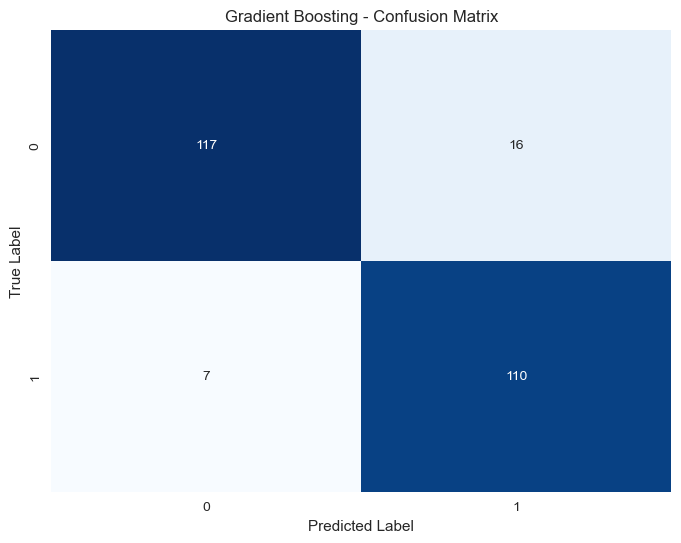

In [4]:
# Create and train a Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Shrinks the contribution of each tree
    max_depth=3,             # Maximum depth of each tree
    min_samples_split=5,     # Minimum samples required to split
    subsample=0.8,           # Fraction of samples for fitting trees
    random_state=42
)

# Train the model
start_time = time.time()
gb_clf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = gb_clf.predict(X_test)
y_prob = gb_clf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("\n--- Gradient Boosting Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Gradient Boosting - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

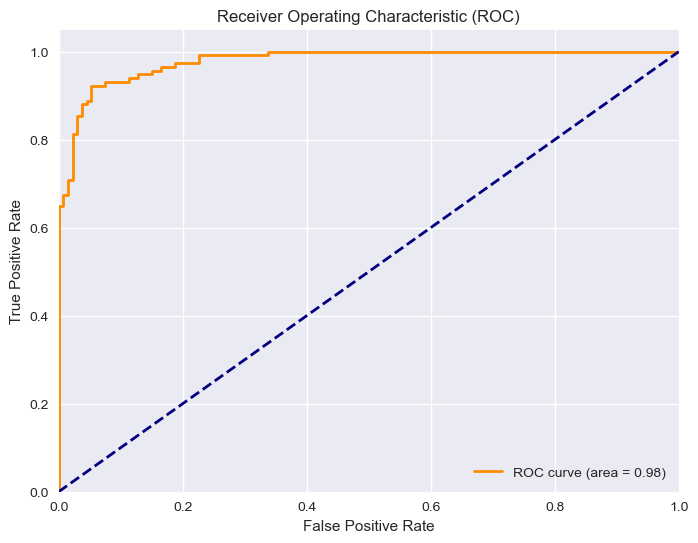

In [5]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **5.2 Regression Example**

Training time: 1.08 seconds

--- Gradient Boosting Regression Results ---
R² Score: 0.9291
Mean Squared  Error: 2590.4549
Mean Absolute Error: 39.5710


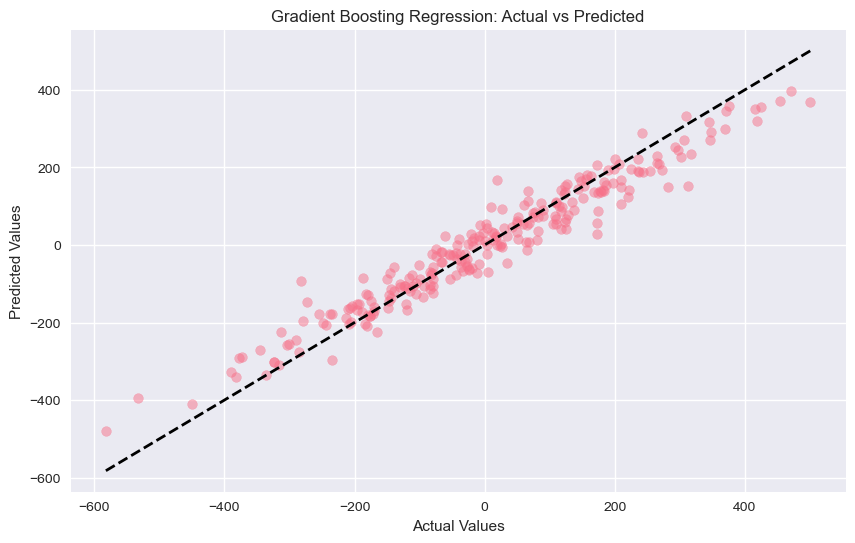

In [7]:
# Generate a synthetic regression dataset
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, n_informative=10,noise=0.1,random_state=42)

# Split the regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# Create and train a Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,           # Stochastic Gradient Boosting with 80% of samples
    loss='squared_error',    # Default loss for regression
    random_state=42
)

# Train the model
start_time = time.time()
gb_reg.fit(X_train_reg, y_train_reg)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred_reg = gb_reg.predict(X_test_reg)

# Evaluate the model
print("\n--- Gradient Boosting Regression Results ---")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared  Error: {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.title('Gradient Boosting Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## **🔍 6. Key Hyperparameters Explained**

Gradient Boosting has several important hyperparameters that affect its behavior and performance:

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **n_estimators** | Number of boosting stages (trees) | 100-500 | Higher values may improve performance but increase training time and risk of overfitting |
| **learning_rate** | Shrinks contribution of each tree | 0.01-0.3 | Lower rates need more trees but may generalize better |
| **max_depth** | Maximum depth of individual trees | 3-8 | Controls model complexity; higher values may lead to overfitting |
| **subsample** | Fraction of samples for each tree | 0.5-1.0 | < 1.0 enables stochastic gradient boosting, reducing variance |
| **min_samples_split** | Minimum samples required to split | 2-20 | Controls overfitting; higher values produce simpler trees |
| **min_samples_leaf** | Minimum samples in leaf nodes | 1-10 | Controls overfitting; higher values produce simpler trees |
| **max_features** | Number of features for best split | 'sqrt', 'log2', None | Controls randomness in feature selection |

### **Loss Functions**

- **For Classification**: 
  - `'deviance'` (default): Logistic regression for binary classification or multinomial deviance for multi-class
  - `'exponential'`: AdaBoost exponential loss

- **For Regression**: 
  - `'squared_error'` (default): L2 loss, sensitive to outliers
  - `'absolute_error'`: L1 loss, more robust to outliers
  - `'huber'`: Combination of squared and absolute error, robust to outliers
  - `'quantile'`: Allows quantile regression

### **Impact of Different Hyperparameter Values**

- **learning_rate and n_estimators**: 
  - Have an inverse relationship: lower learning rates need more trees
  - Lower learning rates often lead to better generalization but require more trees

- **max_depth**: 
  - Too shallow: May underfit
  - Too deep: May overfit
  - Values of 3-5 often work well

- **subsample**: 
  - < 1.0 introduces randomness (stochastic gradient boosting)
  - Can help reduce variance and prevent overfitting
  - Values around 0.8 often work well

## **🔄 7. Hyperparameter Tuning**

In [8]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators'      : [50, 100, 200],
    'learning_rate'     : [0.01, 0.1, 0.2],
    'max_depth'         : [3, 5, 7],
    'subsample'         : [0.7, 0.8, 1.0],
    'min_samples_split' : [2, 5, 10]
}

# Create the gradient boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Create a grid search object with a smaller subset for demonstration
# In practice, you might want to use more combinations or RandomizedSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search (Note: This can take significant time)
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Display best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Create a model with the best parameters
best_gb = grid_search.best_estimator_

# Evaluate on the test set
best_predictions = best_gb.predict(X_test)
print(f"Test accuracy with best parameters: {accuracy_score(y_test, best_predictions):.4f}")

Starting grid search...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9507
Test accuracy with best parameters: 0.9240


## **📊 8. Feature Importance Visualization**

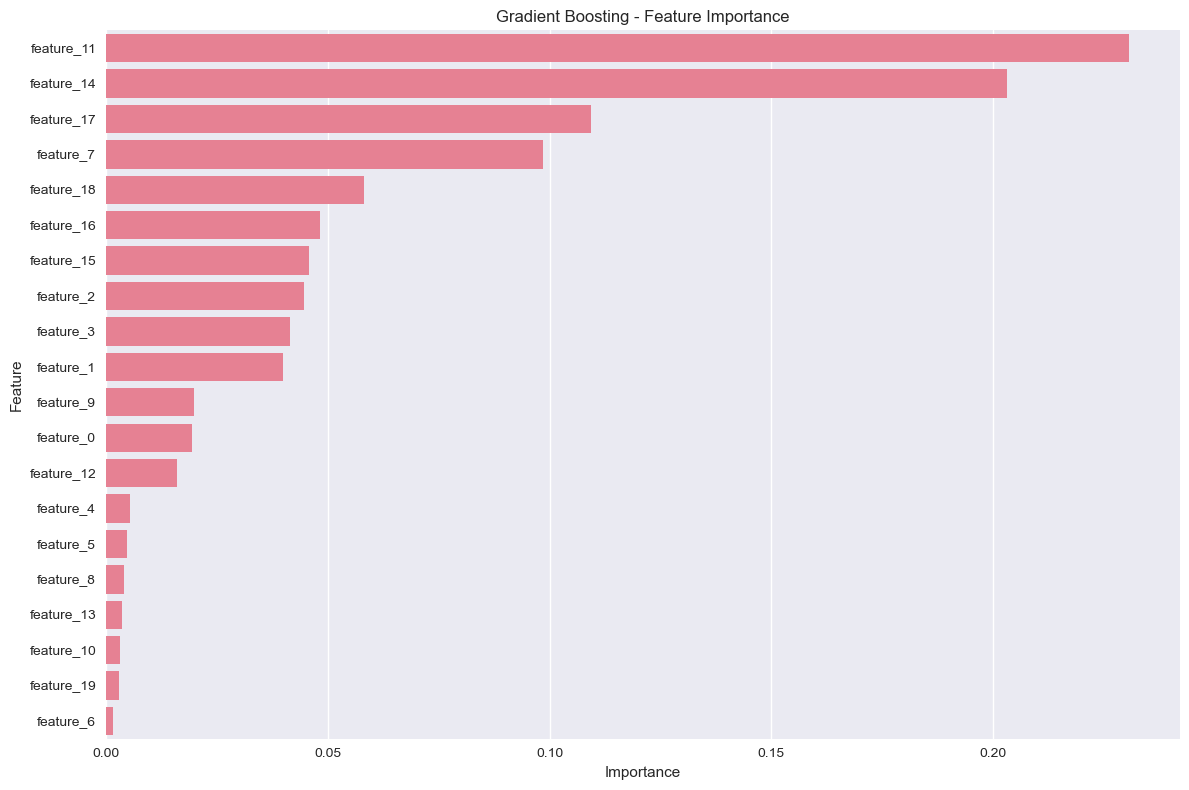

Top 10 Most Important Features:


,Feature,Importance
11,feature_11,0.230636
14,feature_14,0.203170
17,feature_17,0.109274
7,feature_7,0.098427
18,feature_18,0.058072
16,feature_16,0.048136
15,feature_15,0.045776
2,feature_2,0.044540
3,feature_3,0.041489
1,feature_1,0.039810


In [9]:
# Get feature importances from the trained model
feature_importances = gb_clf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Gradient Boosting - Feature Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 Most Important Features:")
display(importance_df.head(10))

## **📈 9. Stagewise Learning Analysis**

One of the unique features of Gradient Boosting in scikit-learn is the ability to monitor performance at each iteration. Let's analyze how the model improves with each added tree.

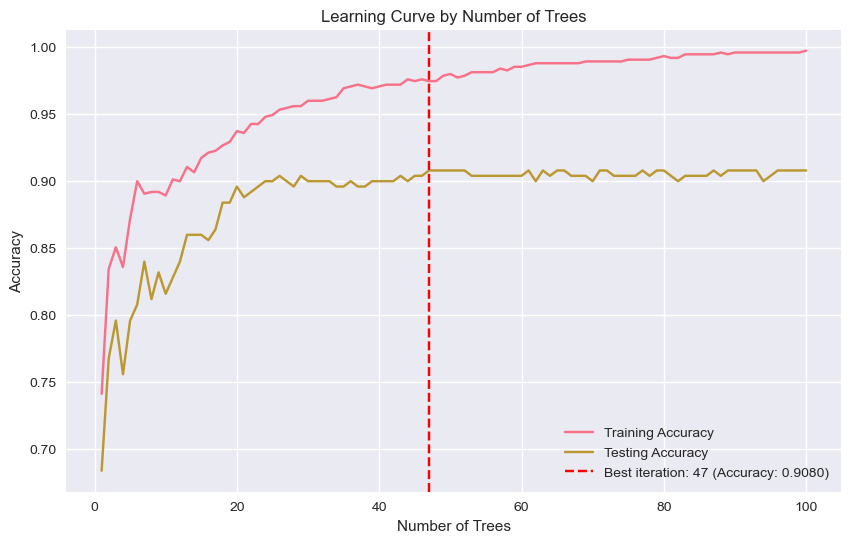

Best number of trees: 47
Test accuracy at best iteration    : 0.91
Final test accuracy with all trees : 0.91


In [11]:
# Extract the staged predictions
staged_train_scores = np.array([accuracy_score(y_train, y_pred) for y_pred in gb_clf.staged_predict(X_train)])
staged_test_scores = np.array([accuracy_score(y_test, y_pred) for y_pred in gb_clf.staged_predict(X_test)])

# Plot the evolution of accuracy over estimators
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(staged_train_scores) + 1), staged_train_scores, label='Training Accuracy')
plt.plot(range(1, len(staged_test_scores) + 1), staged_test_scores, label='Testing Accuracy')

# Find the best iteration
best_iter = np.argmax(staged_test_scores) + 1  # +1 because index starts at 0
plt.axvline(x=best_iter, color='r', linestyle='--', label=f'Best iteration: {best_iter} (Accuracy: {staged_test_scores[best_iter-1]:.4f})')

plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Learning Curve by Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best number of trees: {best_iter}")
print(f"Test accuracy at best iteration    : {staged_test_scores[best_iter-1]:.2f}")
print(f"Final test accuracy with all trees : {staged_test_scores[-1]:.2f}")

## **🔄 10. Comparison with AdaBoost**

Let's compare Gradient Boosting with AdaBoost on the same dataset.

--- Model Comparison ---
Gradient Boosting Accuracy: 0.8920
AdaBoost Accuracy: 0.8200
Difference: 0.0720

Gradient Boosting Training Time: 1.44 seconds
AdaBoost Training Time: 0.71 seconds


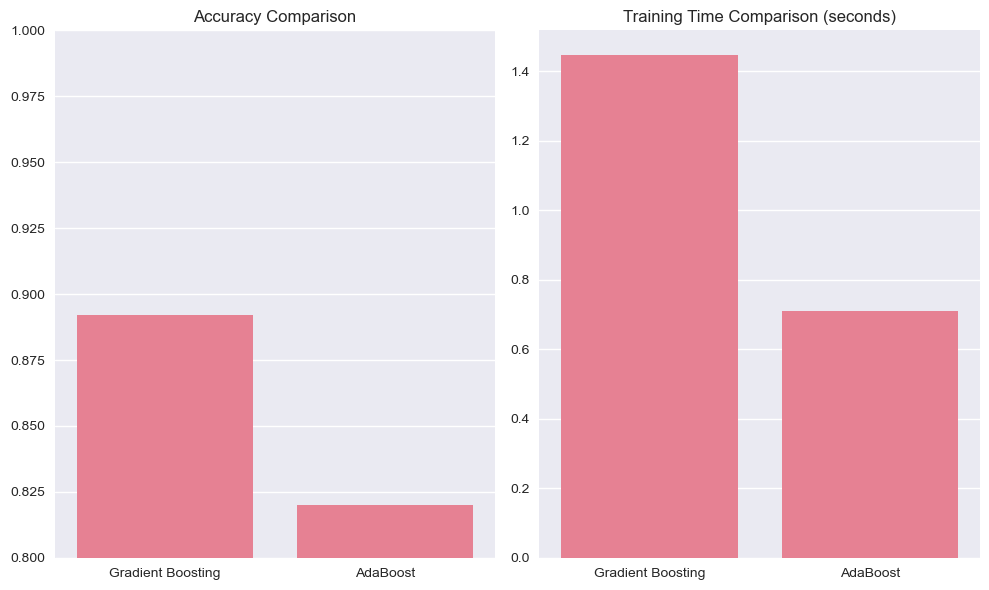

In [12]:
# Create and train an AdaBoost model for comparison
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train both models and measure time
# Gradient Boosting
start_time = time.time()
gb_clf_comp = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf_comp.fit(X_train, y_train)
gb_time = time.time() - start_time
gb_pred = gb_clf_comp.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)

# AdaBoost
start_time = time.time()
ada_clf.fit(X_train, y_train)
ada_time = time.time() - start_time
ada_pred = ada_clf.predict(X_test)
ada_acc = accuracy_score(y_test, ada_pred)

# Compare results
print("--- Model Comparison ---")
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")
print(f"AdaBoost Accuracy: {ada_acc:.4f}")
print(f"Difference: {abs(gb_acc - ada_acc):.4f}")
print(f"\nGradient Boosting Training Time: {gb_time:.2f} seconds")
print(f"AdaBoost Training Time: {ada_time:.2f} seconds")

# Visualize comparison
plt.figure(figsize=(10, 6))
models = ['Gradient Boosting', 'AdaBoost']
accuracies = [gb_acc, ada_acc]
training_times = [gb_time, ada_time]

# Plot accuracy comparison
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed

# Plot training time comparison
plt.subplot(1, 2, 2)
sns.barplot(x=models, y=training_times)
plt.title('Training Time Comparison (seconds)')

plt.tight_layout()
plt.show()

## **💡 11. Best Practices and Tips**

### **When to Choose Gradient Boosting**

- **For structured data**: Excellent for tabular datasets
- **When you need top performance**: Often outperforms other algorithms
- **For feature importance**: Provides reliable importance scores
- **When you have enough training time**: Can be slower than other algorithms

### **Tuning Tips**

1. **Learning rate and n_estimators**:
   - Lower learning rates (0.01-0.1) generally yield better results but need more trees
   - A good strategy: set a small learning rate (e.g., 0.1) and find the optimal n_estimators
   - Use early stopping when possible to avoid overfitting

2. **Tree complexity**:
   - Control with max_depth, min_samples_split, min_samples_leaf
   - Trees too deep: risk of overfitting
   - Trees too shallow: risk of underfitting
   - Start with max_depth=3 or 4

3. **Stochastic variants**:
   - Use subsample < 1.0 (e.g., 0.8) for stochastic gradient boosting
   - Use max_features < 1.0 to introduce more randomness
   - Both help reduce overfitting

4. **Loss functions**:
   - For regression with outliers, try 'huber' or 'absolute_error' instead of 'squared_error'
   - For quantile regression, use 'quantile' with the alpha parameter

### **Practical Considerations**

- **Memory usage**: Can be high for many trees or deep trees
- **Training time**: Often slower than random forests or other algorithms
- **Hyperparameter tuning**: Critical for good performance, but can be time-consuming
- **Regularization**: Consider early stopping, max_depth, min_samples_split, and shrinkage (learning_rate)
- **Warm starts**: sklearn supports warm_start parameter to continue training from a previously trained model

### **Common Pitfalls**

- **Overfitting**: Gradient boosting can easily overfit without proper tuning
- **Not using stochastic variants**: Random sampling of rows/features helps generalization
- **Too many trees**: More isn't always better; monitor validation performance
- **Ignoring early stopping**: Can save computation time and prevent overfitting
- **Poor handling of missing values**: Pre-processing required since sklearn doesn't handle missing values natively

## **📚 12. Additional Resources and Modern Alternatives**

### **Papers and Books**

- [Greedy Function Approximation: A Gradient Boosting Machine](https://jerryfriedman.su.domains/ftp/trebst.pdf) - Original paper by Jerome Friedman
- [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) - Classic textbook with great coverage of boosting

### **Documentation**

- [Scikit-learn GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Scikit-learn GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [Scikit-learn Gradient Boosting Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)

### **Modern Gradient Boosting Alternatives**

While scikit-learn's implementation is great for learning, these more optimized libraries are often preferred in practice:

- **XGBoost**: Optimized gradient boosting library with regularization and parallel processing
- **LightGBM**: Microsoft's high-performance gradient boosting framework using histogram-based algorithm
- **CatBoost**: Yandex's gradient boosting library with better handling of categorical features

These libraries typically offer:
- Better performance and speed
- More sophisticated regularization
- Improved handling of missing values
- Built-in cross-validation and early stopping
- Support for GPU acceleration

---

<h3 align="center">📈 Happy Modeling with Gradient Boosting! 📈</h3>